In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR


import numpy as np
import matplotlib.pyplot as plt




/Users/serafim/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Images in MNIST have pixel values ranging from 0 to 1. After normalization using `transforms.Normalize(mean=(0.5,), std=(0.5,))`, the transformed images have pixel values ranging from -1 to 1.

Due to this transformation, the generator's last layer typically uses the hyperbolic tangent (tanh) activation function to get pixel values ranging from -1 to 1.



In [3]:
BATCH_SIZE = 32

# Image processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# MNIST dataset
train_dataset = MNIST(root='./data', 
                      train=True, 
                      transform=transform,
                      download=True)

test_dataset = MNIST(root='./data', 
                     train=False, 
                     transform=transform,
                     download=True)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

#### CustomMNIST

To restrict the dataset to certain digits, such as creating a dataset with fewer instances of the digit '1', you can use this class.

This can be very useful when you want to make it more challenging for a generator to produce specific digits.

In [333]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, download=False, digit_limits=None):
        self.mnist = MNIST(root=root, train=train, transform=transform, download=download)
        self.transform = transform
        self.digit_limits = digit_limits
        self.indices = self._get_indices()

    def _get_indices(self):
        digit_count = {i: 0 for i in range(10)}
        indices = []

        for i, (image, label) in enumerate(self.mnist):
            limit = self.digit_limits.get(label, None)
            if limit is None or digit_count[label] < limit:
                indices.append(i)
                digit_count[label] += 1

        return indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        idx = self.indices[idx]
        return self.mnist[idx]

    
digit_limits = {2:1000, 8: 1000, 7: 1000}

train_dataset = CustomMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True,
    digit_limits=digit_limits
)
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

In [6]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

##### Mnist samples
Here an image and some pixels from it

In [4]:
img, label = train_dataset[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [5]:
def denorm(x):
    out = (x + 1) / 2
    # print(out)
    return out.clamp(0, 1)

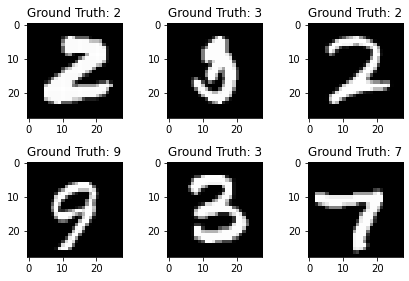

In [6]:
inputs, classes = next(iter(train_loader))
inputs = inputs[:6]
inputs = [el[0] for el in inputs]
classes = classes[:6]

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(denorm(inputs[i]), cmap='gray', interpolation='none');
    plt.title("Ground Truth: {}".format(classes[i]))
    # plt.xticks([])
    # plt.yticks([])
    
plt.tight_layout()
plt.show()

In [4]:
IMAGE_SIZE = 784
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Load pretrained classifier

use it to calculate FID and accuracy

In [5]:
from modules.mnist_classifier import eval_model
from modules.mnist_models import CNN, CNN2, CNN3
CLASSIFIER = CNN3().to(device=device)
PATH = './mnist_tests_classifier/classifier__CNN3__1_9_32/classifier_model.pt'
CLASSIFIER.load_state_dict(torch.load(PATH))
CLASSIFIER.eval()

CNN3(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_sl

In [21]:
# CLASSIFIER
loss_test, accuracy_test = eval_model(test_loader,
                                      CLASSIFIER,
                                      criterion = nn.CrossEntropyLoss(),
                                      device = device)
print(loss_test, accuracy_test)

0.010905277570991165 99.65


### Train


In [8]:
from modules.mnist import Generator, Discriminator, train
from modules.weighted_bce import WeightedVarianceBCE

In [6]:
save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/mnist_tests'
# save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests'
# save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests_v'
# save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests_metric1'
save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests_D'
save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/mnist_tests_D'

In [9]:
G = Generator().to(device=device)
D = Discriminator().to(device=device)
# criterion = nn.BCELoss()
# loss_function = nn.BCELoss()
loss_function = WeightedVarianceBCE()
learning_rate_G = 0.0001
learning_rate_D = 0.0001
# lr = 0.0001
NUM_EPOCHS = 50

import math 
NUM_BATCHES = math.ceil(len(train_loader.dataset)/train_loader.batch_size)
print(f'NUM_BATCHES: {NUM_BATCHES}')
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate_G)
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate_D)

max_lr = 0.00015

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

# save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests'
NAME = 'base_wgan__lr_0,0001__1_3'

D_losses_final, G_losses_final = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    name = NAME, 
    save_path = save_path, 
    progress_generator = True,
    plot_process = True,
    info_n = 1,
    classifier = CLASSIFIER,
    fid = True,
    fid_dataset = train_loader,
    weights_bce = True,
    test_fid = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G
)
# plot_sine(G, save_path = save_path, name = NAME)


NUM_BATCHES: 1875
Folder 'base_wgan__lr_0,0001__1_3' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/mnist_tests_D'.
{0: 2.0590288946894484, 1: 1.9808143540483525, 2: 1.879230503318487, 3: 1.9437755958816214, 4: 1.9302803973789469, 5: 1.9124889686286712, 6: 1.9648104523313539, 7: 2.0067161840243903, 8: 1.8753556160881426, 9: 2.0129704610519705} {0: 0.516944677617915, 1: 0.23961986743031058, 2: 0.505366567847906, 3: 0.4743666069289848, 4: 0.4143690566654459, 5: 0.46986809517743827, 6: 0.4225204800260561, 7: 0.38121657789188323, 8: 0.45889617490314516, 9: 0.3996223346405325}
weights_bce {0: 1.0, 1: 0.9620138693328573, 2: 0.9126780630253957, 3: 0.9440254096943064, 4: 0.9374712527626184, 5: 0.9288305635541463, 6: 0.9542413209445004, 7: 0.9745935033743428, 8: 0.9107961626594812, 9: 0.9776309920874497}
1111111111


  0%|                                                    | 0/50 [00:00<?, ?it/s]

adjusting weights
000
epoch [0/50], average D_loss: 0.5884, average G_loss: 0.5771
calssifier: loss CE -- 13.339899491882324, accuracy -- 10.0


  2%|▊                                        | 1/50 [01:42<1:24:04, 102.96s/it]

adjusting weights
000
epoch [1/50], average D_loss: 0.3585, average G_loss: 0.9597
calssifier: loss CE -- 15.466656295776367, accuracy -- 10.0


  4%|█▋                                       | 2/50 [03:22<1:20:51, 101.08s/it]

adjusting weights
000
epoch [2/50], average D_loss: 0.2151, average G_loss: 1.5595
calssifier: loss CE -- 11.292451651000977, accuracy -- 10.61


  6%|██▍                                      | 3/50 [05:04<1:19:16, 101.19s/it]

adjusting weights
000
epoch [3/50], average D_loss: 0.1856, average G_loss: 2.1178
calssifier: loss CE -- 6.201738236236572, accuracy -- 13.320000000000002


  8%|███▎                                     | 4/50 [06:46<1:18:00, 101.75s/it]

adjusting weights
000
epoch [4/50], average D_loss: 0.1756, average G_loss: 1.5274
calssifier: loss CE -- 5.3610573051452635, accuracy -- 14.66


 10%|████                                     | 5/50 [08:30<1:16:54, 102.55s/it]

adjusting weights
000
epoch [5/50], average D_loss: 0.2214, average G_loss: 1.8852
calssifier: loss CE -- 4.501730918121338, accuracy -- 16.669999999999998


 12%|████▉                                    | 6/50 [10:11<1:14:47, 101.98s/it]

adjusting weights
000
epoch [6/50], average D_loss: 0.2497, average G_loss: 1.7453
calssifier: loss CE -- 3.9056051921844483, accuracy -- 24.04


 14%|█████▋                                   | 7/50 [11:52<1:12:56, 101.79s/it]

adjusting weights
000
epoch [7/50], average D_loss: 0.2833, average G_loss: 1.5030
calssifier: loss CE -- 4.715546868133545, accuracy -- 19.919999999999998


 16%|██████▌                                  | 8/50 [13:34<1:11:14, 101.77s/it]

adjusting weights
000
epoch [8/50], average D_loss: 0.2815, average G_loss: 0.9253
calssifier: loss CE -- 3.910753324508667, accuracy -- 30.659999999999997


 18%|███████▍                                 | 9/50 [15:16<1:09:29, 101.71s/it]

adjusting weights
000
epoch [9/50], average D_loss: 0.3454, average G_loss: 1.1342
calssifier: loss CE -- 2.505941124343872, accuracy -- 51.67


 20%|████████                                | 10/50 [16:56<1:07:36, 101.41s/it]

adjusting weights
000
epoch [10/50], average D_loss: 0.3275, average G_loss: 0.8451
calssifier: loss CE -- 2.220704965400696, accuracy -- 50.870000000000005


 22%|████████▊                               | 11/50 [18:37<1:05:41, 101.07s/it]

adjusting weights
000
epoch [11/50], average D_loss: 0.3681, average G_loss: 0.8913
calssifier: loss CE -- 1.778333267021179, accuracy -- 59.37


 24%|█████████▌                              | 12/50 [20:15<1:03:24, 100.12s/it]

adjusting weights
000
epoch [12/50], average D_loss: 0.2270, average G_loss: 0.4560
calssifier: loss CE -- 1.3612801984786986, accuracy -- 66.29


 26%|██████████▋                              | 13/50 [21:54<1:01:34, 99.85s/it]

adjusting weights
000
epoch [13/50], average D_loss: 0.2570, average G_loss: 0.4331
calssifier: loss CE -- 1.1884631976127624, accuracy -- 70.94


 28%|████████████                               | 14/50 [23:34<59:52, 99.79s/it]

adjusting weights
000
epoch [14/50], average D_loss: 0.3107, average G_loss: 0.5681
calssifier: loss CE -- 0.9959876318395138, accuracy -- 76.51


 30%|████████████▌                             | 15/50 [25:17<58:50, 100.87s/it]

adjusting weights
000
epoch [15/50], average D_loss: 0.3284, average G_loss: 0.5661
calssifier: loss CE -- 0.8950525784015656, accuracy -- 76.23


 32%|█████████████▍                            | 16/50 [26:59<57:21, 101.21s/it]

adjusting weights
000
epoch [16/50], average D_loss: 0.4356, average G_loss: 0.7124
calssifier: loss CE -- 0.7444485376358032, accuracy -- 81.05


 34%|██████████████▎                           | 17/50 [28:43<56:04, 101.96s/it]

adjusting weights
000
epoch [17/50], average D_loss: 0.3558, average G_loss: 0.5401
calssifier: loss CE -- 0.6434710731983185, accuracy -- 83.25


 36%|███████████████                           | 18/50 [30:27<54:43, 102.61s/it]

adjusting weights
000
epoch [18/50], average D_loss: 0.3806, average G_loss: 0.5556
calssifier: loss CE -- 0.6381749833106994, accuracy -- 82.96


 38%|███████████████▉                          | 19/50 [32:09<52:56, 102.45s/it]

adjusting weights
000
epoch [19/50], average D_loss: 0.2362, average G_loss: 0.3213
calssifier: loss CE -- 0.711785157585144, accuracy -- 82.26


 40%|████████████████▊                         | 20/50 [33:50<51:04, 102.15s/it]

adjusting weights
000
epoch [20/50], average D_loss: 0.3579, average G_loss: 0.5027
calssifier: loss CE -- 0.6831936454534531, accuracy -- 82.11


 42%|█████████████████▋                        | 21/50 [35:34<49:37, 102.68s/it]

adjusting weights
000
epoch [21/50], average D_loss: 0.3492, average G_loss: 0.4743
calssifier: loss CE -- 0.5541430864870548, accuracy -- 85.99


 44%|██████████████████▍                       | 22/50 [37:17<47:55, 102.69s/it]

adjusting weights
000
epoch [22/50], average D_loss: 0.3944, average G_loss: 0.5356
calssifier: loss CE -- 0.5540372349977494, accuracy -- 85.96000000000001


 46%|███████████████████▎                      | 23/50 [39:02<46:31, 103.38s/it]

adjusting weights
000
epoch [23/50], average D_loss: 0.2871, average G_loss: 0.3642
calssifier: loss CE -- 0.4526815380513668, accuracy -- 87.91


 48%|████████████████████▏                     | 24/50 [40:46<44:51, 103.52s/it]

adjusting weights
000
epoch [24/50], average D_loss: 0.3171, average G_loss: 0.4038
calssifier: loss CE -- 0.37960955424010756, accuracy -- 89.53


 50%|█████████████████████                     | 25/50 [42:26<42:43, 102.53s/it]

adjusting weights
000
epoch [25/50], average D_loss: 0.4249, average G_loss: 0.5536
calssifier: loss CE -- 0.35267518556714056, accuracy -- 90.91


 52%|█████████████████████▊                    | 26/50 [44:11<41:16, 103.19s/it]

adjusting weights
000
epoch [26/50], average D_loss: 0.3055, average G_loss: 0.3808
calssifier: loss CE -- 0.3177323545470834, accuracy -- 90.69


 54%|██████████████████████▋                   | 27/50 [45:51<39:10, 102.20s/it]

adjusting weights
000
epoch [27/50], average D_loss: 0.3521, average G_loss: 0.4388
calssifier: loss CE -- 0.2826787262707949, accuracy -- 91.95


 56%|███████████████████████▌                  | 28/50 [47:32<37:21, 101.91s/it]

adjusting weights
000
epoch [28/50], average D_loss: 0.3725, average G_loss: 0.4651
calssifier: loss CE -- 0.2742612610846758, accuracy -- 92.42


 58%|████████████████████████▎                 | 29/50 [49:15<35:48, 102.33s/it]

adjusting weights
000
epoch [29/50], average D_loss: 0.4368, average G_loss: 0.5423
calssifier: loss CE -- 0.1928720073387027, accuracy -- 94.46


 60%|█████████████████████████▏                | 30/50 [50:56<33:57, 101.86s/it]

adjusting weights
000
epoch [30/50], average D_loss: 0.2569, average G_loss: 0.3134
calssifier: loss CE -- 0.17748873171079904, accuracy -- 94.98


 62%|██████████████████████████                | 31/50 [52:39<32:21, 102.19s/it]

adjusting weights
000
epoch [31/50], average D_loss: 0.2272, average G_loss: 0.2788
calssifier: loss CE -- 0.19414998726174235, accuracy -- 94.67


 64%|██████████████████████████▉               | 32/50 [54:21<30:38, 102.12s/it]

adjusting weights
000
epoch [32/50], average D_loss: 0.3023, average G_loss: 0.3703
calssifier: loss CE -- 0.16638040627539158, accuracy -- 94.84


 66%|███████████████████████████▋              | 33/50 [56:01<28:46, 101.58s/it]

adjusting weights
000
epoch [33/50], average D_loss: 0.2537, average G_loss: 0.3086
calssifier: loss CE -- 0.1849667295690626, accuracy -- 94.72


 68%|████████████████████████████▌             | 34/50 [57:47<27:26, 102.88s/it]

adjusting weights
000
epoch [34/50], average D_loss: 0.4205, average G_loss: 0.5056
calssifier: loss CE -- 0.1985774940341711, accuracy -- 94.51


 70%|█████████████████████████████▍            | 35/50 [59:35<26:03, 104.26s/it]

adjusting weights
000
epoch [35/50], average D_loss: 0.3418, average G_loss: 0.4083
calssifier: loss CE -- 0.15310146205928177, accuracy -- 95.41


 72%|████████████████████████████▊           | 36/50 [1:01:13<23:57, 102.64s/it]

adjusting weights
000
epoch [36/50], average D_loss: 0.3253, average G_loss: 0.3833
calssifier: loss CE -- 0.177808913109079, accuracy -- 94.99


 74%|█████████████████████████████▌          | 37/50 [1:02:59<22:25, 103.49s/it]

adjusting weights
000
epoch [37/50], average D_loss: 0.3023, average G_loss: 0.3597
calssifier: loss CE -- 0.12828152710190044, accuracy -- 96.3


 76%|██████████████████████████████▍         | 38/50 [1:04:44<20:49, 104.12s/it]

adjusting weights
000
epoch [38/50], average D_loss: 0.3007, average G_loss: 0.3525
calssifier: loss CE -- 0.10672673035599291, accuracy -- 96.83


 78%|███████████████████████████████▏        | 39/50 [1:06:30<19:09, 104.54s/it]

adjusting weights
000
epoch [39/50], average D_loss: 0.3510, average G_loss: 0.4108
calssifier: loss CE -- 0.12639778249105438, accuracy -- 96.46000000000001


 80%|████████████████████████████████        | 40/50 [1:08:17<17:31, 105.15s/it]

adjusting weights
000
epoch [40/50], average D_loss: 0.3735, average G_loss: 0.4380
calssifier: loss CE -- 0.12665169309973717, accuracy -- 96.38


 82%|████████████████████████████████▊       | 41/50 [1:09:57<15:33, 103.67s/it]

adjusting weights
000
epoch [41/50], average D_loss: 0.3273, average G_loss: 0.3796
calssifier: loss CE -- 0.11018826930709183, accuracy -- 96.72


 84%|█████████████████████████████████▌      | 42/50 [1:11:38<13:42, 102.80s/it]

adjusting weights
000
epoch [42/50], average D_loss: 0.3594, average G_loss: 0.4200
calssifier: loss CE -- 0.10274989835841115, accuracy -- 97.05


 86%|██████████████████████████████████▍     | 43/50 [1:13:23<12:04, 103.51s/it]

adjusting weights
000
epoch [43/50], average D_loss: 0.3486, average G_loss: 0.4060
calssifier: loss CE -- 0.11180018699802459, accuracy -- 97.07000000000001


 88%|███████████████████████████████████▏    | 44/50 [1:15:11<10:30, 105.09s/it]

adjusting weights
000
epoch [44/50], average D_loss: 0.3519, average G_loss: 0.4099
calssifier: loss CE -- 0.09784840305838734, accuracy -- 97.16


 90%|████████████████████████████████████    | 45/50 [1:17:00<08:50, 106.14s/it]

adjusting weights
000
epoch [45/50], average D_loss: 0.3344, average G_loss: 0.3907
calssifier: loss CE -- 0.11744893643148244, accuracy -- 96.83


 92%|████████████████████████████████████▊   | 46/50 [1:19:21<07:45, 116.46s/it]

adjusting weights
000
epoch [46/50], average D_loss: 0.3328, average G_loss: 0.3918
calssifier: loss CE -- 0.10570486879888923, accuracy -- 97.00999999999999


 94%|█████████████████████████████████████▌  | 47/50 [1:21:35<06:05, 121.74s/it]

adjusting weights
000
epoch [47/50], average D_loss: 0.3084, average G_loss: 0.3625
calssifier: loss CE -- 0.11252118288176134, accuracy -- 96.71


 96%|██████████████████████████████████████▍ | 48/50 [1:23:48<04:10, 125.07s/it]

adjusting weights
000
epoch [48/50], average D_loss: 0.3471, average G_loss: 0.4055
calssifier: loss CE -- 0.11224353312877938, accuracy -- 96.83


 98%|███████████████████████████████████████▏| 49/50 [1:25:57<02:06, 126.43s/it]

adjusting weights
000
epoch [49/50], average D_loss: 0.3326, average G_loss: 0.3894
calssifier: loss CE -- 0.10682260439116507, accuracy -- 97.14


100%|████████████████████████████████████████| 50/50 [1:28:11<00:00, 105.84s/it]


In [ ]:
Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=512, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

Save model, Generator and Discriminator

In [15]:
import os
def save_model(model, save_path, name, name2):
    filepath = os.path.join(save_path, name, name2)
    model.eval()
    torch.save(model.state_dict(), filepath)
    print(f"Model saved at: {filepath}")
    


In [16]:
save_model(G, save_path, NAME, name2 = 'Generator')
save_model(D, save_path, NAME, name2 = 'Discriminator')

Model saved at: /Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/mnist_tests_D/base_wgan__lr_0,0001__1_3/Generator
Model saved at: /Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/mnist_tests_D/base_wgan__lr_0,0001__1_3/Discriminator


In [323]:
G = Generator().to(device=device)
D = Discriminator().to(device=device)
# criterion = nn.BCELoss()
# loss_function = nn.BCELoss()
loss_function = WeightedVarianceBCE()
learning_rate_G = 0.0001
learning_rate_D = 0.0001
# lr = 0.0001
NUM_EPOCHS = 50

import math 
NUM_BATCHES = math.ceil(len(train_loader.dataset)/train_loader.batch_size)
print(f'NUM_BATCHES: {NUM_BATCHES}')
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate_G)
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate_D)

max_lr = 0.00015

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

# save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests'
NAME = 'base_wgan__lr_0,0001__1_3'

D_losses_final, G_losses_final = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    name = NAME, 
    save_path = save_path, 
    progress_generator = True,
    plot_process = True,
    info_n = 1,
    classifier = CLASSIFIER,
    fid = True,
    fid_dataset = train_loader,
    weights_bce = True,
    test_fid = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G
)
# plot_sine(G, save_path = save_path, name = NAME)


NUM_BATCHES: 1404
Folder 'base_wgan__lr_0,0001__1_3' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests_D'.


KeyboardInterrupt: 

In [ ]:
save_model(G, save_path, NAME, name2 = 'Generator')
save_model(D, save_path, NAME, name2 = 'Discriminator')

### Training without weights

In [150]:
G = Generator().to(device=device)
D = Discriminator().to(device=device)
# criterion = nn.BCELoss()
# loss_function = nn.BCELoss()
loss_function = WeightedVarianceBCE()
learning_rate_G = 0.0001
learning_rate_D = 0.0001
# lr = 0.0001
NUM_EPOCHS = 50

import math 
NUM_BATCHES = math.ceil(len(train_loader.dataset)/train_loader.batch_size)
print(f'NUM_BATCHES: {NUM_BATCHES}')
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate_G)
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate_D)

max_lr = 0.00015

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

NAME = 'base_gan__lr_0,0001__1_6'

D_losses_final, G_losses_final = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    name = NAME, 
    save_path = save_path, 
    progress_generator = True,
    plot_process = True,
    info_n = 1,
    classifier = CLASSIFIER,
    fid = True,
    fid_dataset = train_loader,
    weights_bce = False,
    test_fid = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G
)


NUM_BATCHES: 1404
Folder 'base_gan__lr_0,0001__1_6' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests'.
{0: 952.1810989183673, 1: 664.2314306518855, 2: 1259.3929442281267, 3: 1276.2262913926259, 4: 1413.296977773921, 5: 1077.0530068345233, 6: 1175.0033123915562, 7: 954.9084633166467, 8: 1088.1589549142857, 9: 1101.5715726670264} {0: 194.95508573477355, 1: 112.43296873782299, 2: 362.8427733296892, 3: 256.1489598496571, 4: 261.52561546923357, 5: 299.4418007798358, 6: 224.00856141499364, 7: 265.13685687133426, 8: 309.904377277567, 9: 215.457192784214}


  0%|                                                                       | 0/50 [00:00<?, ?it/s]

without weights
epoch [0/50], average D_loss: 0.6208, average G_loss: 0.5782
calssifier: loss CE -- 12.598875975036622, accuracy -- 10.0


  2%|█▏                                                           | 1/50 [01:38<1:20:04, 98.05s/it]

without weights
epoch [1/50], average D_loss: 0.4828, average G_loss: 1.0001
calssifier: loss CE -- 15.97602526397705, accuracy -- 10.0


  4%|██▍                                                          | 2/50 [03:15<1:18:16, 97.85s/it]

without weights
epoch [2/50], average D_loss: 0.2257, average G_loss: 2.2974
calssifier: loss CE -- 10.719432341003419, accuracy -- 10.01


  6%|███▋                                                         | 3/50 [04:53<1:16:31, 97.69s/it]

without weights
epoch [3/50], average D_loss: 0.2644, average G_loss: 2.5252
calssifier: loss CE -- 9.834565473937989, accuracy -- 9.99


  8%|████▉                                                        | 4/50 [06:30<1:14:42, 97.46s/it]

without weights
epoch [4/50], average D_loss: 0.2638, average G_loss: 2.8181
calssifier: loss CE -- 6.507478345489502, accuracy -- 12.91


 10%|██████                                                       | 5/50 [08:10<1:13:50, 98.44s/it]

without weights
epoch [5/50], average D_loss: 0.3443, average G_loss: 2.3565
calssifier: loss CE -- 4.48578660736084, accuracy -- 22.67


 12%|███████▎                                                     | 6/50 [09:48<1:11:58, 98.14s/it]

without weights
epoch [6/50], average D_loss: 0.3108, average G_loss: 2.6429
calssifier: loss CE -- 4.747601499938964, accuracy -- 17.68


 14%|████████▌                                                    | 7/50 [11:26<1:10:16, 98.06s/it]

without weights
epoch [7/50], average D_loss: 0.3808, average G_loss: 2.1155
calssifier: loss CE -- 3.143770023727417, accuracy -- 38.74


 16%|█████████▊                                                   | 8/50 [13:04<1:08:39, 98.08s/it]

without weights
epoch [8/50], average D_loss: 0.4520, average G_loss: 1.6659
calssifier: loss CE -- 3.061079365539551, accuracy -- 41.949999999999996


 18%|██████████▉                                                  | 9/50 [14:42<1:07:01, 98.08s/it]

without weights
epoch [9/50], average D_loss: 0.5022, average G_loss: 1.3995
calssifier: loss CE -- 2.950967380142212, accuracy -- 41.06


 20%|████████████                                                | 10/50 [16:20<1:05:23, 98.10s/it]

without weights
epoch [10/50], average D_loss: 0.4924, average G_loss: 1.4629
calssifier: loss CE -- 2.894771407318115, accuracy -- 44.18


 22%|█████████████▏                                              | 11/50 [17:58<1:03:41, 97.98s/it]

without weights
epoch [11/50], average D_loss: 0.5337, average G_loss: 1.2324
calssifier: loss CE -- 2.8186855567932128, accuracy -- 46.1


 24%|██████████████▍                                             | 12/50 [19:35<1:01:58, 97.86s/it]

without weights
epoch [12/50], average D_loss: 0.5490, average G_loss: 1.1893
calssifier: loss CE -- 2.6912651958465577, accuracy -- 47.410000000000004


 26%|███████████████▌                                            | 13/50 [21:13<1:00:20, 97.84s/it]

without weights
epoch [13/50], average D_loss: 0.5538, average G_loss: 1.1528
calssifier: loss CE -- 2.4336718910217283, accuracy -- 52.83


 28%|█████████████████▎                                            | 14/50 [22:51<58:49, 98.06s/it]

without weights
epoch [14/50], average D_loss: 0.5772, average G_loss: 1.0653
calssifier: loss CE -- 1.8918819845199586, accuracy -- 62.970000000000006


 30%|██████████████████▌                                           | 15/50 [24:29<57:02, 97.80s/it]

without weights
epoch [15/50], average D_loss: 0.6038, average G_loss: 0.9791
calssifier: loss CE -- 1.5104483912467956, accuracy -- 66.18


 32%|███████████████████▊                                          | 16/50 [26:06<55:18, 97.60s/it]

without weights
epoch [16/50], average D_loss: 0.6175, average G_loss: 0.9352
calssifier: loss CE -- 1.4160032861709595, accuracy -- 66.31


 34%|█████████████████████                                         | 17/50 [27:43<53:36, 97.46s/it]

without weights
epoch [17/50], average D_loss: 0.6271, average G_loss: 0.9047
calssifier: loss CE -- 0.9008567312240601, accuracy -- 77.17


 36%|██████████████████████▎                                       | 18/50 [29:20<51:55, 97.37s/it]

without weights
epoch [18/50], average D_loss: 0.6255, average G_loss: 0.8980
calssifier: loss CE -- 0.8246816999435425, accuracy -- 80.47999999999999


 38%|███████████████████████▌                                      | 19/50 [30:57<50:13, 97.22s/it]

without weights
epoch [19/50], average D_loss: 0.6312, average G_loss: 0.8840
calssifier: loss CE -- 0.975721423625946, accuracy -- 75.24


 40%|████████████████████████▊                                     | 20/50 [32:34<48:37, 97.25s/it]

without weights
epoch [20/50], average D_loss: 0.6263, average G_loss: 0.9028
calssifier: loss CE -- 1.1908021913528442, accuracy -- 70.94


 42%|██████████████████████████                                    | 21/50 [34:11<46:57, 97.16s/it]

without weights
epoch [21/50], average D_loss: 0.6350, average G_loss: 0.8743
calssifier: loss CE -- 0.5813988325834274, accuracy -- 84.07


 44%|███████████████████████████▎                                  | 22/50 [35:48<45:19, 97.11s/it]

without weights
epoch [22/50], average D_loss: 0.6414, average G_loss: 0.8585
calssifier: loss CE -- 0.5783075961947441, accuracy -- 84.57000000000001


 46%|████████████████████████████▌                                 | 23/50 [37:27<43:53, 97.53s/it]

without weights
epoch [23/50], average D_loss: 0.6445, average G_loss: 0.8509
calssifier: loss CE -- 0.6893581768751145, accuracy -- 82.13000000000001


 48%|█████████████████████████████▊                                | 24/50 [39:11<43:09, 99.61s/it]

without weights
epoch [24/50], average D_loss: 0.6449, average G_loss: 0.8430
calssifier: loss CE -- 0.6556534551143646, accuracy -- 82.67999999999999


 50%|███████████████████████████████                               | 25/50 [40:51<41:29, 99.57s/it]

without weights
epoch [25/50], average D_loss: 0.6397, average G_loss: 0.8656
calssifier: loss CE -- 0.761998677110672, accuracy -- 79.9


 52%|███████████████████████████████▋                             | 26/50 [42:32<40:01, 100.07s/it]

without weights
epoch [26/50], average D_loss: 0.6473, average G_loss: 0.8414
calssifier: loss CE -- 0.5500312265813351, accuracy -- 85.47


 54%|█████████████████████████████████▍                            | 27/50 [44:10<38:08, 99.52s/it]

without weights
epoch [27/50], average D_loss: 0.6480, average G_loss: 0.8395
calssifier: loss CE -- 0.44937722071409225, accuracy -- 87.06


 56%|██████████████████████████████████▋                           | 28/50 [45:50<36:33, 99.71s/it]

without weights
epoch [28/50], average D_loss: 0.6519, average G_loss: 0.8239
calssifier: loss CE -- 0.31500881707668305, accuracy -- 90.92


 58%|███████████████████████████████████▍                         | 29/50 [47:36<35:28, 101.36s/it]

without weights
epoch [29/50], average D_loss: 0.6549, average G_loss: 0.8195
calssifier: loss CE -- 0.49718663989305495, accuracy -- 85.61999999999999


 60%|████████████████████████████████████▌                        | 30/50 [49:17<33:45, 101.27s/it]

without weights
epoch [30/50], average D_loss: 0.6570, average G_loss: 0.8077
calssifier: loss CE -- 0.47908610259890555, accuracy -- 86.44


 62%|█████████████████████████████████████▊                       | 31/50 [51:01<32:20, 102.15s/it]

without weights
epoch [31/50], average D_loss: 0.6544, average G_loss: 0.8306
calssifier: loss CE -- 0.5062911327004432, accuracy -- 87.32


 64%|███████████████████████████████████████                      | 32/50 [52:43<30:41, 102.30s/it]

without weights
epoch [32/50], average D_loss: 0.6500, average G_loss: 0.8325
calssifier: loss CE -- 0.3487948504447937, accuracy -- 89.75999999999999


 66%|████████████████████████████████████████▎                    | 33/50 [54:30<29:19, 103.48s/it]

without weights
epoch [33/50], average D_loss: 0.6554, average G_loss: 0.8127
calssifier: loss CE -- 0.3418283471047878, accuracy -- 90.78


 68%|█████████████████████████████████████████▍                   | 34/50 [56:15<27:42, 103.89s/it]

without weights
epoch [34/50], average D_loss: 0.6542, average G_loss: 0.8129
calssifier: loss CE -- 0.3150515723645687, accuracy -- 91.74


 70%|██████████████████████████████████████████▋                  | 35/50 [57:59<26:00, 104.05s/it]

without weights
epoch [35/50], average D_loss: 0.6573, average G_loss: 0.8035
calssifier: loss CE -- 0.37649531146734955, accuracy -- 90.05


 72%|███████████████████████████████████████████▉                 | 36/50 [59:41<24:09, 103.53s/it]

without weights
epoch [36/50], average D_loss: 0.6552, average G_loss: 0.8015
calssifier: loss CE -- 0.3798559166114777, accuracy -- 89.3


 74%|███████████████████████████████████████████▋               | 37/50 [1:01:26<22:29, 103.77s/it]

without weights
epoch [37/50], average D_loss: 0.6548, average G_loss: 0.8028
calssifier: loss CE -- 0.41945975774079564, accuracy -- 89.67


 76%|████████████████████████████████████████████▊              | 38/50 [1:03:08<20:40, 103.36s/it]

without weights
epoch [38/50], average D_loss: 0.6543, average G_loss: 0.8018
calssifier: loss CE -- 0.33434907580316064, accuracy -- 90.74


 78%|██████████████████████████████████████████████             | 39/50 [1:04:52<18:59, 103.60s/it]

without weights
epoch [39/50], average D_loss: 0.6616, average G_loss: 0.7811
calssifier: loss CE -- 0.23316906498074533, accuracy -- 93.16


 80%|███████████████████████████████████████████████▏           | 40/50 [1:06:36<17:15, 103.60s/it]

without weights
epoch [40/50], average D_loss: 0.6597, average G_loss: 0.7826
calssifier: loss CE -- 0.22768217951357364, accuracy -- 93.11


 82%|████████████████████████████████████████████████▍          | 41/50 [1:08:17<15:27, 103.01s/it]

without weights
epoch [41/50], average D_loss: 0.6594, average G_loss: 0.7783
calssifier: loss CE -- 0.16105297398939727, accuracy -- 94.78


 84%|█████████████████████████████████████████████████▌         | 42/50 [1:10:01<13:45, 103.23s/it]

without weights
epoch [42/50], average D_loss: 0.6610, average G_loss: 0.7732
calssifier: loss CE -- 0.23598578940741718, accuracy -- 93.08999999999999


 86%|██████████████████████████████████████████████████▋        | 43/50 [1:11:41<11:55, 102.22s/it]

without weights
epoch [43/50], average D_loss: 0.6616, average G_loss: 0.7690
calssifier: loss CE -- 0.24060354747921228, accuracy -- 92.65


 88%|███████████████████████████████████████████████████▉       | 44/50 [1:13:19<10:06, 101.03s/it]

without weights
epoch [44/50], average D_loss: 0.6603, average G_loss: 0.7731
calssifier: loss CE -- 0.2535349397642538, accuracy -- 92.86999999999999


 90%|█████████████████████████████████████████████████████      | 45/50 [1:15:02<08:27, 101.56s/it]

without weights
epoch [45/50], average D_loss: 0.6618, average G_loss: 0.7725
calssifier: loss CE -- 0.24864015426784755, accuracy -- 92.97


 92%|██████████████████████████████████████████████████████▎    | 46/50 [1:16:42<06:44, 101.09s/it]

without weights
epoch [46/50], average D_loss: 0.6600, average G_loss: 0.7736
calssifier: loss CE -- 0.30527580855339764, accuracy -- 91.63


 94%|███████████████████████████████████████████████████████▍   | 47/50 [1:18:22<05:02, 100.71s/it]

without weights
epoch [47/50], average D_loss: 0.6606, average G_loss: 0.7744
calssifier: loss CE -- 0.3356298503249884, accuracy -- 91.14999999999999


 96%|████████████████████████████████████████████████████████▋  | 48/50 [1:20:04<03:22, 101.07s/it]

without weights
epoch [48/50], average D_loss: 0.6595, average G_loss: 0.7715
calssifier: loss CE -- 0.2698442070990801, accuracy -- 92.7


 98%|█████████████████████████████████████████████████████████▊ | 49/50 [1:21:45<01:41, 101.03s/it]

without weights
epoch [49/50], average D_loss: 0.6598, average G_loss: 0.7703
calssifier: loss CE -- 0.28706757837086916, accuracy -- 92.13


100%|███████████████████████████████████████████████████████████| 50/50 [1:23:24<00:00, 100.09s/it]


Save model

In [151]:
save_model(G, save_path, NAME, name2 = 'Generator')
save_model(D, save_path, NAME, name2 = 'Discriminator')

Model saved at: /Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests/base_gan__lr_0,0001__1_6/Generator
Model saved at: /Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests/base_gan__lr_0,0001__1_6/Discriminator


In [152]:
G = Generator().to(device=device)
D = Discriminator().to(device=device)
# criterion = nn.BCELoss()
# loss_function = nn.BCELoss()
loss_function = WeightedVarianceBCE()
learning_rate_G = 0.0001
learning_rate_D = 0.0001
# lr = 0.0001
NUM_EPOCHS = 50

import math 
NUM_BATCHES = math.ceil(len(train_loader.dataset)/train_loader.batch_size)
print(f'NUM_BATCHES: {NUM_BATCHES}')
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate_G)
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate_D)

max_lr = 0.00015

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

NAME = 'base_gan__lr_0,0001__1_8'

D_losses_final, G_losses_final = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    name = NAME, 
    save_path = save_path, 
    progress_generator = True,
    plot_process = True,
    info_n = 1,
    classifier = CLASSIFIER,
    fid = True,
    fid_dataset = train_loader,
    weights_bce = False,
    test_fid = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G
)


NUM_BATCHES: 1404
Folder 'base_gan__lr_0,0001__1_8' created at '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests'.
{0: 948.6219929546646, 1: 665.0866367949675, 2: 1260.3220304506658, 3: 1275.14603915087, 4: 1409.0729608992228, 5: 1075.9504585653208, 6: 1172.9033280590859, 7: 952.7642208273899, 8: 1081.7811866510897, 9: 1096.2969416146373} {0: 194.75047195857087, 1: 112.41067243949873, 2: 362.7689298647284, 3: 256.02305331102616, 4: 261.5453730085979, 5: 299.18245319422704, 6: 223.84980022705454, 7: 264.80786096410856, 8: 310.22771985421457, 9: 215.23981270838735}


  0%|                                                                       | 0/50 [00:00<?, ?it/s]

without weights
epoch [0/50], average D_loss: 0.6156, average G_loss: 0.5824
calssifier: loss CE -- 14.15434386291504, accuracy -- 10.0


  2%|█▏                                                          | 1/50 [01:49<1:29:15, 109.29s/it]

without weights
epoch [1/50], average D_loss: 0.4513, average G_loss: 1.0893
calssifier: loss CE -- 16.833543867492676, accuracy -- 10.0


  4%|██▍                                                         | 2/50 [03:33<1:24:51, 106.07s/it]

without weights
epoch [2/50], average D_loss: 0.2140, average G_loss: 2.3288
calssifier: loss CE -- 9.917585949707032, accuracy -- 10.01


  6%|███▌                                                        | 3/50 [05:14<1:21:16, 103.75s/it]

without weights
epoch [3/50], average D_loss: 0.2633, average G_loss: 2.4681
calssifier: loss CE -- 7.787853649902344, accuracy -- 10.85


  8%|████▊                                                       | 4/50 [06:56<1:19:04, 103.14s/it]

without weights
epoch [4/50], average D_loss: 0.2560, average G_loss: 2.8512
calssifier: loss CE -- 5.777663674926758, accuracy -- 14.78


 10%|██████                                                      | 5/50 [08:42<1:18:05, 104.11s/it]

without weights
epoch [5/50], average D_loss: 0.3096, average G_loss: 2.5584
calssifier: loss CE -- 3.7815592185974123, accuracy -- 22.470000000000002


 12%|███████▏                                                    | 6/50 [10:30<1:17:23, 105.53s/it]

without weights
epoch [6/50], average D_loss: 0.3435, average G_loss: 2.3080
calssifier: loss CE -- 3.95753038482666, accuracy -- 22.439999999999998


 14%|████████▍                                                   | 7/50 [12:09<1:14:06, 103.40s/it]

without weights
epoch [7/50], average D_loss: 0.3799, average G_loss: 2.0676
calssifier: loss CE -- 2.818491665458679, accuracy -- 38.3


 16%|█████████▌                                                  | 8/50 [13:49<1:11:31, 102.19s/it]

without weights
epoch [8/50], average D_loss: 0.4399, average G_loss: 1.6691
calssifier: loss CE -- 3.4475729484558104, accuracy -- 36.04


 18%|██████████▊                                                 | 9/50 [15:26<1:08:53, 100.81s/it]

without weights
epoch [9/50], average D_loss: 0.4609, average G_loss: 1.5487
calssifier: loss CE -- 2.9710285999298094, accuracy -- 41.53


 20%|███████████▊                                               | 10/50 [17:06<1:06:53, 100.34s/it]

without weights
epoch [10/50], average D_loss: 0.4979, average G_loss: 1.4050
calssifier: loss CE -- 2.761327763938904, accuracy -- 47.0


 22%|█████████████▏                                              | 11/50 [18:44<1:04:55, 99.88s/it]

without weights
epoch [11/50], average D_loss: 0.5234, average G_loss: 1.2860
calssifier: loss CE -- 2.4586476499557497, accuracy -- 53.94


 24%|██████████████▍                                             | 12/50 [20:24<1:03:17, 99.93s/it]

without weights
epoch [12/50], average D_loss: 0.5692, average G_loss: 1.1018
calssifier: loss CE -- 2.6134456378936766, accuracy -- 51.11


 26%|███████████████▌                                            | 13/50 [22:04<1:01:30, 99.74s/it]

without weights
epoch [13/50], average D_loss: 0.5742, average G_loss: 1.0819
calssifier: loss CE -- 2.3443994747161865, accuracy -- 55.42


 28%|█████████████████▎                                            | 14/50 [23:43<59:47, 99.65s/it]

without weights
epoch [14/50], average D_loss: 0.5954, average G_loss: 0.9952
calssifier: loss CE -- 1.880147177028656, accuracy -- 61.08


 30%|██████████████████▌                                           | 15/50 [25:23<58:05, 99.59s/it]

without weights
epoch [15/50], average D_loss: 0.5982, average G_loss: 0.9954
calssifier: loss CE -- 1.7777908699512481, accuracy -- 63.61


 32%|███████████████████▊                                          | 16/50 [27:02<56:23, 99.51s/it]

without weights
epoch [16/50], average D_loss: 0.5976, average G_loss: 0.9907
calssifier: loss CE -- 1.9564659395217896, accuracy -- 65.66


 34%|█████████████████████                                         | 17/50 [28:41<54:40, 99.41s/it]

without weights
epoch [17/50], average D_loss: 0.6080, average G_loss: 0.9480
calssifier: loss CE -- 1.9231907687187195, accuracy -- 67.36


 36%|██████████████████████▎                                       | 18/50 [30:20<52:57, 99.31s/it]

without weights
epoch [18/50], average D_loss: 0.6228, average G_loss: 0.9125
calssifier: loss CE -- 1.4338909161090851, accuracy -- 72.22


 38%|███████████████████████▌                                      | 19/50 [31:57<50:57, 98.62s/it]

without weights
epoch [19/50], average D_loss: 0.6309, average G_loss: 0.8853
calssifier: loss CE -- 1.559926407289505, accuracy -- 70.45


 40%|████████████████████████▊                                     | 20/50 [33:35<49:15, 98.51s/it]

without weights
epoch [20/50], average D_loss: 0.6328, average G_loss: 0.8804
calssifier: loss CE -- 0.7810901921987533, accuracy -- 83.07


 42%|██████████████████████████                                    | 21/50 [35:13<47:30, 98.30s/it]

without weights
epoch [21/50], average D_loss: 0.6384, average G_loss: 0.8644
calssifier: loss CE -- 0.9120686956644058, accuracy -- 77.97


 44%|███████████████████████████▎                                  | 22/50 [36:52<45:59, 98.54s/it]

without weights
epoch [22/50], average D_loss: 0.6395, average G_loss: 0.8609
calssifier: loss CE -- 0.6857348772525788, accuracy -- 83.3


 46%|████████████████████████████▌                                 | 23/50 [38:31<44:21, 98.56s/it]

without weights
epoch [23/50], average D_loss: 0.6452, average G_loss: 0.8438
calssifier: loss CE -- 0.6779260382294655, accuracy -- 82.34


 48%|█████████████████████████████▊                                | 24/50 [40:12<43:03, 99.35s/it]

without weights
epoch [24/50], average D_loss: 0.6450, average G_loss: 0.8419
calssifier: loss CE -- 0.9889541147470474, accuracy -- 81.62


 50%|███████████████████████████████                               | 25/50 [41:52<41:23, 99.36s/it]

without weights
epoch [25/50], average D_loss: 0.6507, average G_loss: 0.8295
calssifier: loss CE -- 0.49938047455251217, accuracy -- 87.0


 52%|████████████████████████████████▏                             | 26/50 [43:31<39:44, 99.37s/it]

without weights
epoch [26/50], average D_loss: 0.6561, average G_loss: 0.8192
calssifier: loss CE -- 0.8556829926729203, accuracy -- 79.84


 54%|█████████████████████████████████▍                            | 27/50 [45:11<38:06, 99.43s/it]

without weights
epoch [27/50], average D_loss: 0.6518, average G_loss: 0.8173
calssifier: loss CE -- 0.748954770720005, accuracy -- 82.64


 56%|██████████████████████████████████▋                           | 28/50 [46:50<36:26, 99.37s/it]

without weights
epoch [28/50], average D_loss: 0.6569, average G_loss: 0.8047
calssifier: loss CE -- 0.6321177147269249, accuracy -- 86.09


 58%|███████████████████████████████████▉                          | 29/50 [48:29<34:47, 99.42s/it]

without weights
epoch [29/50], average D_loss: 0.6593, average G_loss: 0.8008
calssifier: loss CE -- 0.5734466055989266, accuracy -- 87.03


 60%|█████████████████████████████████████▏                        | 30/50 [50:09<33:08, 99.42s/it]

without weights
epoch [30/50], average D_loss: 0.6549, average G_loss: 0.8102
calssifier: loss CE -- 0.512243911910057, accuracy -- 88.11


 62%|██████████████████████████████████████▍                       | 31/50 [51:48<31:27, 99.34s/it]

without weights
epoch [31/50], average D_loss: 0.6553, average G_loss: 0.8066
calssifier: loss CE -- 0.557759206700325, accuracy -- 86.14


 64%|███████████████████████████████████████▋                      | 32/50 [53:27<29:47, 99.30s/it]

without weights
epoch [32/50], average D_loss: 0.6581, average G_loss: 0.7936
calssifier: loss CE -- 0.34128030075728893, accuracy -- 91.4


 66%|████████████████████████████████████████▉                     | 33/50 [55:07<28:13, 99.62s/it]

without weights
epoch [33/50], average D_loss: 0.6596, average G_loss: 0.7911
calssifier: loss CE -- 0.32183263963386416, accuracy -- 91.69


 68%|██████████████████████████████████████████▏                   | 34/50 [56:46<26:30, 99.42s/it]

without weights
epoch [34/50], average D_loss: 0.6630, average G_loss: 0.7821
calssifier: loss CE -- 0.39050892628729345, accuracy -- 90.02


 70%|███████████████████████████████████████████▍                  | 35/50 [58:26<24:51, 99.41s/it]

without weights
epoch [35/50], average D_loss: 0.6643, average G_loss: 0.7788
calssifier: loss CE -- 0.3347220532685518, accuracy -- 90.93


 72%|███████████████████████████████████████████▏                | 36/50 [1:00:05<23:09, 99.28s/it]

without weights
epoch [36/50], average D_loss: 0.6644, average G_loss: 0.7752
calssifier: loss CE -- 0.2630530856266618, accuracy -- 92.9


 74%|████████████████████████████████████████████▍               | 37/50 [1:01:44<21:31, 99.32s/it]

without weights
epoch [37/50], average D_loss: 0.6665, average G_loss: 0.7682
calssifier: loss CE -- 0.28768830984458327, accuracy -- 92.25999999999999


 76%|█████████████████████████████████████████████▌              | 38/50 [1:03:23<19:51, 99.29s/it]

without weights
epoch [38/50], average D_loss: 0.6651, average G_loss: 0.7680
calssifier: loss CE -- 0.3340439149826765, accuracy -- 91.45


 78%|██████████████████████████████████████████████▊             | 39/50 [1:05:03<18:13, 99.40s/it]

without weights
epoch [39/50], average D_loss: 0.6661, average G_loss: 0.7641
calssifier: loss CE -- 0.27284127160422506, accuracy -- 92.51


 80%|████████████████████████████████████████████████            | 40/50 [1:06:43<16:35, 99.53s/it]

without weights
epoch [40/50], average D_loss: 0.6666, average G_loss: 0.7635
calssifier: loss CE -- 0.3286216589868069, accuracy -- 91.36


 82%|█████████████████████████████████████████████████▏          | 41/50 [1:08:22<14:54, 99.40s/it]

without weights
epoch [41/50], average D_loss: 0.6689, average G_loss: 0.7548
calssifier: loss CE -- 0.30798882029727104, accuracy -- 91.69


 84%|██████████████████████████████████████████████████▍         | 42/50 [1:10:01<13:15, 99.39s/it]

without weights
epoch [42/50], average D_loss: 0.6680, average G_loss: 0.7558
calssifier: loss CE -- 0.32451997036263347, accuracy -- 91.14999999999999


 86%|███████████████████████████████████████████████████▌        | 43/50 [1:11:42<11:39, 99.88s/it]

without weights
epoch [43/50], average D_loss: 0.6670, average G_loss: 0.7572
calssifier: loss CE -- 0.27101989653110503, accuracy -- 92.21000000000001


 88%|████████████████████████████████████████████████████▊       | 44/50 [1:13:22<09:59, 99.94s/it]

without weights
epoch [44/50], average D_loss: 0.6668, average G_loss: 0.7554
calssifier: loss CE -- 0.22610577537342905, accuracy -- 93.54


 90%|██████████████████████████████████████████████████████      | 45/50 [1:15:02<08:18, 99.79s/it]

without weights
epoch [45/50], average D_loss: 0.6670, average G_loss: 0.7555
calssifier: loss CE -- 0.23683653507977723, accuracy -- 93.61


 92%|███████████████████████████████████████████████████████▏    | 46/50 [1:16:42<06:39, 99.89s/it]

without weights
epoch [46/50], average D_loss: 0.6658, average G_loss: 0.7587
calssifier: loss CE -- 0.21767743168920278, accuracy -- 93.7


 94%|████████████████████████████████████████████████████████▍   | 47/50 [1:18:22<04:59, 99.84s/it]

without weights
epoch [47/50], average D_loss: 0.6644, average G_loss: 0.7585
calssifier: loss CE -- 0.2367640531539917, accuracy -- 93.36


 96%|█████████████████████████████████████████████████████████▌  | 48/50 [1:20:01<03:19, 99.77s/it]

without weights
epoch [48/50], average D_loss: 0.6659, average G_loss: 0.7627
calssifier: loss CE -- 0.23928473348654808, accuracy -- 93.03


 98%|██████████████████████████████████████████████████████████▊ | 49/50 [1:21:41<01:39, 99.68s/it]

without weights
epoch [49/50], average D_loss: 0.6663, average G_loss: 0.7600
calssifier: loss CE -- 0.22012406674213708, accuracy -- 93.67


100%|███████████████████████████████████████████████████████████| 50/50 [1:23:21<00:00, 100.02s/it]


In [153]:
save_model(G, save_path, NAME, name2 = 'Generator')
save_model(D, save_path, NAME, name2 = 'Discriminator')

Model saved at: /Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests/base_gan__lr_0,0001__1_8/Generator
Model saved at: /Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests/base_gan__lr_0,0001__1_8/Discriminator


In [ ]:
G = Generator().to(device=device)
D = Discriminator().to(device=device)
# criterion = nn.BCELoss()
# loss_function = nn.BCELoss()
loss_function = WeightedVarianceBCE()
learning_rate_G = 0.0001
learning_rate_D = 0.0001
# lr = 0.0001
NUM_EPOCHS = 50

import math 
NUM_BATCHES = math.ceil(len(train_loader.dataset)/train_loader.batch_size)
print(f'NUM_BATCHES: {NUM_BATCHES}')
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate_G)
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate_D)

max_lr = 0.0005

scheduler_D = OneCycleLR(D_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)
scheduler_G = OneCycleLR(G_optimizer, max_lr=max_lr, total_steps=NUM_EPOCHS * NUM_BATCHES)

NAME = 'base_gan__lr_0,0001__1_6'

D_losses_final, G_losses_final = train(
    num_epochs = NUM_EPOCHS,
    data_loader = train_loader,
    D = D,
    G = G,
    D_optimizer = D_optimizer,
    G_optimizer = G_optimizer, 
    criterion = loss_function,
    device = device,
    name = NAME, 
    save_path = save_path, 
    progress_generator = True,
    plot_process = True,
    info_n = 1,
    classifier = CLASSIFIER,
    fid = True,
    fid_dataset = train_loader,
    weights_bce = False,
    test_fid = True,
    scheduler_D = scheduler_D,
    scheduler_G = scheduler_G
)


In [51]:
save_model(G, save_path, NAME, name2 = 'Generator')
save_model(D, save_path, NAME, name2 = 'Discriminator')

Model saved at: /Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests/base_gan__lr_0,0001__1_4/Generator
Model saved at: /Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests/base_gan__lr_0,0001__1_4/Discriminator


### Compare models(with weights and without it)

> load lists with fid and vfid for every class for model with weights and without it and compare thier values


In [12]:
import pickle
import os

In [20]:


m1_path_base = 'mnist_tests/base_gan__lr_0,0001__1_8'
m2_path_base = 'mnist_tests/base_wgan__lr_0,0001__1_3'

# m1_path = f'{m1_path_base}/fid_test.pickle' 'mnist_tests/base_gan__lr_0,0001__1_12/fid_test.pickle' 
# m2_path = 'mnist_tests/base_wgan__lr_0,0001__1_11/fid_test.pickle'

m1_fid_path = os.path.join(m1_path_base, f'fid_test.pickle')
m2_fid_path = os.path.join(m2_path_base, f'fid_test.pickle')

m1_vfid_path = os.path.join(m1_path_base, f'vfid_test.pickle')
m2_vfid_path = os.path.join(m2_path_base, f'vfid_test.pickle')


with open(m1_fid_path, 'rb') as f:
    m1_fid = pickle.load(f)
    
with open(m2_fid_path, 'rb') as f:
    m2_fid = pickle.load(f)
    
with open(m1_vfid_path, 'rb') as f:
    m1_vfid = pickle.load(f)
    
with open(m2_vfid_path, 'rb') as f:
    m2_vfid = pickle.load(f)

In [31]:
def plot_grouped_bar(m1, m2, title, y_label, x_label = 'digits', bar_width=0.35, legend_labels=('Standard', 'Weighted'),
                    save_path = None):
    """
    Plots a grouped bar chart with two sets of data.
    
    Args:
    - m1 (list): List of tuples containing x, y values for the first set of bars.
    - m2 (list): List of tuples containing x, y values for the second set of bars.
    - title (str): Title of the plot.
    - x_label (str): Label for the x-axis.
    - y_label (str): Label for the y-axis.
    - bar_width (float): Width of the bars. Default is 0.35.
    - legend_labels (tuple): Labels for the legend. Default is ('Standard', 'Weighted').
    """
    
    # Extract the x values (indices) and y values
    x = [item[0] for item in m1]
    y1 = [item[1] for item in m1]
    y2 = [item[1] for item in m2]

    # Define the positions of the bars for m1 and m2
    x_pos_m1 = np.array(x) - bar_width / 2
    x_pos_m2 = np.array(x) + bar_width / 2
    
    # Create the bar plot
    plt.bar(x_pos_m1, y1, width=bar_width, label=legend_labels[0], color='r')
    plt.bar(x_pos_m2, y2, width=bar_width, label=legend_labels[1], color='black')
    
    # Labeling and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(x)  # Set the ticks at the center of the groups
    plt.legend()
    if save_path:
        save_filename = os.path.join(save_path,  'fid4digits')
        plt.savefig(save_filename, dpi=300)
        plt.close()
        return

    # Show the plot
    plt.show()

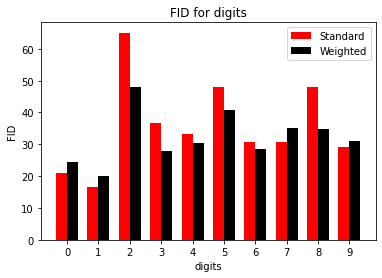

In [22]:
plot_grouped_bar(m1_fid, m2_fid, title = 'FID for digits', y_label = 'FID')

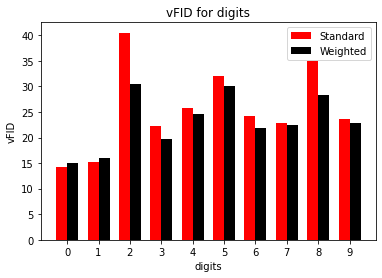

In [23]:
plot_grouped_bar(m1_vfid, m2_vfid, title = 'vFID for digits', y_label = 'vFID')

In [178]:
os.path

<module 'posixpath' from '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/posixpath.py'>

Load standard and weighted Generator and Discriminator

In [27]:
standard_model_path = 'base_gan__lr_0,0001__1_4'
# standard_model_path = 'base_wgan__lr_0,0001__1_1'
w_model_path = 'base_wgan__lr_0,0001__1_3'
save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests_metric1'
save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests'
save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/mnist_tests'
# save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests_v'
# save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/custom_mnist_tests_D'
# save_path = '/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/mnist_tests_D'

In [28]:
standard_G = Generator().to(device=device)
standard_D = Discriminator().to(device=device)

path = os.path.join(save_path, standard_model_path, 'Generator')
standard_G.load_state_dict(torch.load(path))
standard_G.eval();

path = os.path.join(save_path, standard_model_path, 'Discriminator')
standard_D.load_state_dict(torch.load(path))
standard_D.eval();

In [330]:
standard_D.eval()

Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=512, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [17]:
Weighted_G = Generator().to(device=device)
Weighted_D = Discriminator().to(device=device)

path = os.path.join(save_path, w_model_path, 'Generator')
Weighted_G.load_state_dict(torch.load(path))
Weighted_G.eval();

path = os.path.join(save_path, w_model_path, 'Discriminator')
Weighted_D.load_state_dict(torch.load(path))
Weighted_D.eval();

Load classifier to get feature representation model

In [18]:
from modules.mnist_classifier import eval_model
from modules.mnist_models import CNN, CNN2, CNN3
CLASSIFIER = CNN3().to(device=device)
PATH = './mnist_tests_classifier/classifier__CNN3__1_9_32/classifier_model.pt'
CLASSIFIER.load_state_dict(torch.load(PATH))
CLASSIFIER.eval()

CNN3(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_sl

In [19]:
from modules.mnist_models import CNNClassifierWrapper

FEATURE_EXTRACTOR = CNNClassifierWrapper(CLASSIFIER, layer_index = -6, use_global_pooling = False)
FEATURE_EXTRACTOR.register_hook()

Check that FEATURE_EXTRACTOR works correctly

In [160]:
# FEATURE_EXTRACTOR = CNNClassifierWrapper(CLASSIFIER, layer_index = -6, use_global_pooling = False)

img_example = torch.rand(32, 1, 28, 28)  #image 28 on 28 with 1 chanel like in mnist
# FEATURE_EXTRACTOR.register_hook()  # Register hook before making predictions
output = FEATURE_EXTRACTOR(img_example)
# FEATURE_EXTRACTOR.remove_hook()
print(output.size())

torch.Size([32, 512])


In [21]:
from modules.fid import split_mnist_loader_cats, calculate_multiple_fid
from modules.mnist_classifier import calculate_confusion_matrix
from modules.mnist import get_fake_dataloader, FakeDataset

In [22]:
fake_loader_eval = get_fake_dataloader(Weighted_G,
                                              device,
                                              batch_size=32,
                                              num_examples_per_class=10000,
                                              noise_dim=100,
                                              shuffle=True)

In [109]:
# fake_loader_eval[0]

In [110]:
# ls
# ls /Users/serafim/Desktop

In [282]:
a = calculate_confusion_matrix(CLASSIFIER, fake_loader_eval, device, epoch = 50, save_path = '/Users/serafim/Desktop', name = 'cf', metrics = True)


In [23]:
b = calculate_confusion_matrix(CLASSIFIER, fake_loader_eval, device, epoch = 50, save_path = '/Users/serafim/Desktop', name = 'cf', metrics = True)


In [24]:
b

{'0': {'precision': 0.9941854636591478,
  'recall': 0.9917,
  'f1-score': 0.9929411764705882,
  'support': 10000},
 '1': {'precision': 0.9871601966094894,
  'recall': 0.9841,
  'f1-score': 0.9856277229706044,
  'support': 10000},
 '2': {'precision': 0.9770847862907244,
  'recall': 0.9807,
  'f1-score': 0.9788890552477917,
  'support': 10000},
 '3': {'precision': 0.9586309523809524,
  'recall': 0.9663,
  'f1-score': 0.9624501992031872,
  'support': 10000},
 '4': {'precision': 0.9778813727435033,
  'recall': 0.9859,
  'f1-score': 0.9818743153072405,
  'support': 10000},
 '5': {'precision': 0.9681451612903226,
  'recall': 0.9604,
  'f1-score': 0.9642570281124498,
  'support': 10000},
 '6': {'precision': 0.980458287868267,
  'recall': 0.9884,
  'f1-score': 0.9844131268363129,
  'support': 10000},
 '7': {'precision': 0.9401461315183666,
  'recall': 0.9393,
  'f1-score': 0.9397228752938823,
  'support': 10000},
 '8': {'precision': 0.972543497938248,
  'recall': 0.967,
  'f1-score': 0.9697638

In [347]:
b

{'0': {'precision': 0.9780740740740741,
  'recall': 0.9903,
  'f1-score': 0.9841490683229813,
  'support': 10000},
 '1': {'precision': 0.9798830641165395,
  'recall': 0.9888,
  'f1-score': 0.984321337912498,
  'support': 10000},
 '2': {'precision': 0.9842393787117405,
  'recall': 0.8618,
  'f1-score': 0.9189592663680957,
  'support': 10000},
 '3': {'precision': 0.9230623639632819,
  'recall': 0.9754,
  'f1-score': 0.9485097486264403,
  'support': 10000},
 '4': {'precision': 0.9730133439553874,
  'recall': 0.9771,
  'f1-score': 0.9750523899810398,
  'support': 10000},
 '5': {'precision': 0.945517109539285,
  'recall': 0.9892,
  'f1-score': 0.9668654090509237,
  'support': 10000},
 '6': {'precision': 0.9802165354330709,
  'recall': 0.9959,
  'f1-score': 0.9879960317460317,
  'support': 10000},
 '7': {'precision': 0.9433779119930975,
  'recall': 0.8747,
  'f1-score': 0.907741801577418,
  'support': 10000},
 '8': {'precision': 0.9584051724137931,
  'recall': 0.8894,
  'f1-score': 0.9226141

In [283]:
a

{'0': {'precision': 0.9946856512583977,
  'recall': 0.992,
  'f1-score': 0.9933410103639914,
  'support': 10000},
 '1': {'precision': 0.9928492295296606,
  'recall': 0.9858,
  'f1-score': 0.9893120578052086,
  'support': 10000},
 '2': {'precision': 0.9903242408646423,
  'recall': 0.9621,
  'f1-score': 0.9760081156479837,
  'support': 10000},
 '3': {'precision': 0.9619526925012581,
  'recall': 0.9557,
  'f1-score': 0.9588161524956107,
  'support': 10000},
 '4': {'precision': 0.9828931572629052,
  'recall': 0.9825,
  'f1-score': 0.9826965393078616,
  'support': 10000},
 '5': {'precision': 0.9550716107514224,
  'recall': 0.9736,
  'f1-score': 0.964246805981975,
  'support': 10000},
 '6': {'precision': 0.9862809424396063,
  'recall': 0.9921,
  'f1-score': 0.9891819133556008,
  'support': 10000},
 '7': {'precision': 0.9579030195731287,
  'recall': 0.9739,
  'f1-score': 0.9658352754499926,
  'support': 10000},
 '8': {'precision': 0.9691987719124493,
  'recall': 0.9786,
  'f1-score': 0.973876

In [ ]:
'accuracy': 0.98388,
 'macro avg': {'precision': 0.9839122704969807,
  'recall': 0.9838800000000001,
  'f1-score': 0.9838827441740126,
  'support': 100000},
 'weighted avg': {'precision': 0.9839122704969808,
  'recall': 0.98388,
  'f1-score': 0.9838827441740123,
  'support': 100000}}




In [18]:

# category_data_real = split_mnist_loader_cats(train_loader, max_images = None)
# fid_cats, vfid_cats = calculate_multiple_fid(standard_G, FEATURE_EXTRACTOR, category_data_real, device)


In [25]:
category_data_real = split_mnist_loader_cats(test_loader, max_images = None)

In [41]:
# fid_cats, vfid_cats = calculate_multiple_fid(standard_G, FEATURE_EXTRACTOR, category_data_real, device)
w_fid_cats, w_vfid_cats = calculate_multiple_fid(Weighted_G, FEATURE_EXTRACTOR, category_data_real, device)


In [235]:
# w_fid_cats, w_vfid_cats

custom dataset with `{2:1000, 8: 1000, 7: 1000}`(there are 1000 images of 2, and etc...)

In [350]:
plot_grouped_bar(list(fid_cats.items()), list(w_fid_cats.items()), title = 'FID for digits', y_label = 'FID', save_path = '/Users/serafim/Desktop/cf')

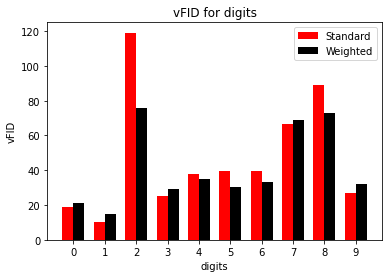

In [351]:
plot_grouped_bar(list(vfid_cats.items()), list(w_vfid_cats.items()), title = 'vFID for digits', y_label = 'vFID')

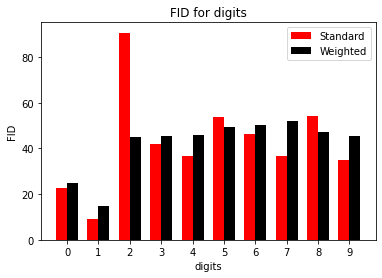

In [35]:
plot_grouped_bar(list(fid_cats.items()), list(w_fid_cats.items()), title = 'FID for digits', y_label = 'FID')

In [42]:
sum(fid_cats.values())/len(fid_cats), sum(w_fid_cats.values())/len(w_fid_cats)

(42.73318215552381, 42.95883731505394)

In [ ]:
(34.62795008633528, 36.0239711077637)

standard dataset

In [ ]:
plot_grouped_bar(list(fid_cats.items()), list(w_fid_cats.items()), title = 'FID for digits', y_label = 'FID')


In [ ]:
plot_grouped_bar(list(vfid_cats.items()), list(w_vfid_cats.items()), title = 'vFID for digits', y_label = 'vFID')

In [308]:
sum(fid_cats.values())/len(fid_cats)

87.92219366591685

In [309]:
sum(w_fid_cats.values())/len(w_fid_cats)

68.5584964665752

In [294]:
# plot_grouped_bar(list(fid_cats.items()), list(w_fid_cats.items()), title = 'FID for digits', y_label = 'FID', save_path = '/Users/serafim/Desktop/cf')

In [47]:
a, b = calculate_multiple_fid(Weighted_G, FEATURE_EXTRACTOR, category_data_real, device)

In [49]:
a

{0: 196.26971342834383,
 1: 104.77639108243164,
 2: 348.7643231859217,
 3: 246.946262029369,
 4: 251.4037574358366,
 5: 297.6989749184397,
 6: 236.92337471797947,
 7: 260.4103219580959,
 8: 296.8813508833998,
 9: 209.83111314012837}

In [51]:
# b

TypeError: float() argument must be a string or a number, not 'dict'

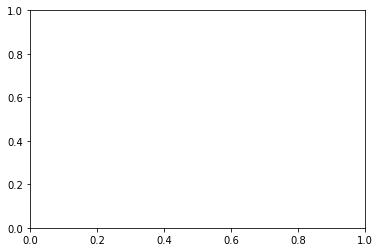

In [52]:
plt.plot(a)

In [62]:
# Extracting keys and values
keys = list(a.keys())
values = list(a.values())

# Creating the bar plot
plt.figure(figsize=(8, 5))
plt.bar(keys, values, color='red')

# Adding titles and labels
plt.title('Trace of Covariance Matrix for Real Objects in MNIST')
plt.xlabel('Digits')
plt.ylabel('Trace Value')

save_filename = os.path.join(save_path,  'var4digits')
plt.savefig(save_filename, dpi=300)
plt.close()
# Display the plot
# plt.show()

In [60]:
save_filename

'/Users/serafim/Desktop/Job/projects/science/hse/GAN-Estimation-Uncertainty/uncertainty/mnist_tests/var4digits'